In [1]:
from datetime import date
import numpy as np
import mne as mne
import matplotlib.pyplot as plt

ELECTRODES_NUM = 35

today = date.today().strftime("%b-%d-%Y")
month = date.today().strftime("%B")
# root_folder = f"data/{month}/{today}"
root_folder = "data/December/Dec-18-2022"

In [2]:
subject = '05_23_12_Itamer'

channels = ['F5','F3','F1','Fz','F2','F4','F6','FC5','FC3','FC1','FCz','FC2','FC4','FC6','C5','C3','C1','Cz','C2','C4','C6','CP5','CP3','CP1','CPz','CP2','CP4','CP6','P5','P3','P1','Pz','P2','P4','P6']
raw = mne.io.read_raw_eeglab(f"C:/Users/alonb/OneDrive - Technion/טכניון/סמסטר ט' - אביב 2022/פרוייקט א/מאטלב/igor_data/{subject}/Training/EEG SET FILTERED/EEG_Data_01.set")
events = mne.events_from_annotations(raw, regexp="[Ss]  [124]")
epochs = mne.Epochs(raw, events[0], tmin=0.1, tmax=0.8, baseline=None, preload=True, picks=channels)

x = 2

Reading C:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\מאטלב\igor_data\05_23_12_Itamer\Training\EEG SET FILTERED\EEG_Data_01.fdt
Used Annotations descriptions: ['S  1', 'S  2', 'S  4']
Not setting metadata
500 matching events found
No baseline correction applied
0 projection items activated
Loading data for 500 events and 351 original time points ...


C:\Users\alonb\AppData\Local\Temp\ipykernel_6596\2691971724.py:4: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(f"C:/Users/alonb/OneDrive - Technion/טכניון/סמסטר ט' - אביב 2022/פרוייקט א/מאטלב/igor_data/{subject}/Training/EEG SET FILTERED/EEG_Data_01.set")


0 bad epochs dropped


In [3]:
# Create the train set and test set
total_num_of_epochs = len(epochs)

train_set_indexes = []
test_set_indexes = []
for i in range(total_num_of_epochs):
    random_num = np.random.rand()
    if (random_num < 0.8):  # 80% chance of being here
        train_set_indexes.append(i)
    else:
        test_set_indexes.append(i)

train_set = epochs[train_set_indexes]
test_set = epochs[test_set_indexes]

print(f"Total number of Epochs: {total_num_of_epochs}")

Total number of Epochs: 500


In [4]:
# Fit ICA on trimmed data
ica = mne.preprocessing.ICA(n_components = ELECTRODES_NUM, method='picard')
ica.fit(train_set)
# ica.save(root_folder + '/' + subject + '/ica.fif', overwrite=True)

Fitting ICA to data using 35 channels (please be patient, this may take a while)


C:\Users\alonb\AppData\Local\Temp\ipykernel_6596\1190229666.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(train_set)


Selecting by number: 35 components
Fitting ICA took 20.4s.


Method,picard
Fit,102 iterations on epochs (146016 samples)
ICA components,35
Explained variance,100.0 %
Available PCA components,35
Channel types,eeg
ICA components marked for exclusion,—


In [5]:
# Export the data
mne.export.export_epochs(root_folder + '/' + subject + '/train_set.set', train_set, overwrite=True)
mne.export.export_epochs(root_folder + '/' + subject + '/test_set.set', test_set, overwrite=True)

In [263]:
# # Import the data
# train_set = mne.io.read_epochs_eeglab(root_folder + '/train_set.set')
# test_set = mne.io.read_epochs_eeglab(root_folder + '/test_set.set')
# ica = mne.preprocessing.read_ica(root_folder + '/ica.fif')

In [6]:
obj_train_ICs = ica.get_sources(train_set)
obj_test_ICs = ica.get_sources(test_set)

train_data = np.swapaxes(obj_train_ICs.copy().get_data(), 0, 1)
test_data = np.swapaxes(obj_test_ICs.copy().get_data(), 0, 1)

train_labels = obj_train_ICs.events[:,2]
test_labels = obj_test_ICs.events[:,2]

The average accuracy is 0.384.
The average F1 score is 0.337.


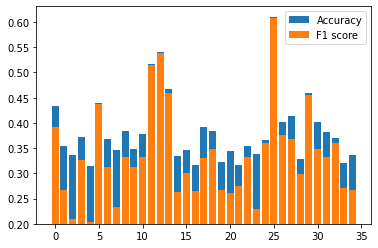

In [7]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score


f1_scores = []
accuracy_scores = []
predictions = []
for i in range(ELECTRODES_NUM):
    clf = GaussianNB()
    predictions.append(cross_val_predict(clf, train_data[i], train_labels))
    f1_scores.append(cross_val_score(clf, train_data[i], train_labels, scoring='f1_macro').mean())
    accuracy_scores.append(cross_val_score(clf, train_data[i], train_labels).mean())
    
f1_scores = np.array(f1_scores)
accuracy_scores = np.array(accuracy_scores)
print(f"The average accuracy is {round(accuracy_scores.mean(),3)}.")
print(f"The average F1 score is {round(f1_scores.mean(),3)}.")

bottom = 0.2
x = np.arange(ELECTRODES_NUM)
plt.bar(x, accuracy_scores-bottom, bottom=bottom, label="Accuracy")
plt.bar(x, f1_scores-bottom, bottom=bottom, label="F1 score")
plt.legend();

In [10]:
acc_thresh = 0.42
f1_thresh = acc_thresh - 0.02
chosen_idxs_by_acc = np.where(accuracy_scores > acc_thresh)
chosen_idxs_by_f1 = np.where(f1_scores > f1_thresh)
chosen_idxs = tuple(np.intersect1d(chosen_idxs_by_acc, chosen_idxs_by_f1))
print(chosen_idxs)

reconstructed_train = ica.apply(train_set.copy(), include=chosen_idxs)
reconstructed_test = ica.apply(test_set.copy(), include=chosen_idxs)
mne.export.export_epochs(root_folder + '/' + subject + '/reconstructed_train.set', reconstructed_train, overwrite=True)
mne.export.export_epochs(root_folder + '/' + subject + '/reconstructed_test.set', reconstructed_test, overwrite=True)

(5, 11, 12, 13, 25, 29)
Applying ICA to Epochs instance
    Transforming to ICA space (35 components)
    Zeroing out 29 ICA components
    Projecting back using 35 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (35 components)
    Zeroing out 29 ICA components
    Projecting back using 35 PCA components
Overwriting existing file.
Overwriting existing file.


The average accuracy is 0.365.
The average F1 score is 0.319.


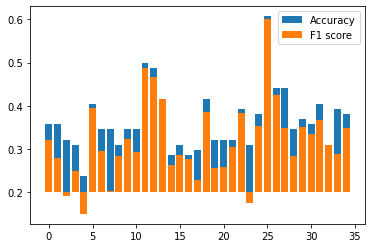

In [11]:
from sklearn.metrics import accuracy_score, f1_score

eval_f1_scores = []
eval_accuracy_scores = []
for i in range(ELECTRODES_NUM):
    # clf = SVC()
    clf = GaussianNB()
    clf.fit(train_data[i], train_labels)
    prediction = clf.predict(test_data[i])
    eval_accuracy_scores.append(accuracy_score(test_labels, prediction))
    eval_f1_scores.append(f1_score(test_labels, prediction, average='macro'))
    # ConfusionMatrixDisplay.from_predictions(test_labels, prediction)
    # print(f"{classification_report(test_labels, prediction)}\n")

eval_f1_scores = np.array(eval_f1_scores) 
eval_accuracy_scores = np.array(eval_accuracy_scores) 
print(f"The average accuracy is {round(eval_accuracy_scores.mean(),3)}.")
print(f"The average F1 score is {round(eval_f1_scores.mean(),3)}.")
bottom = 0.2
x = np.arange(ELECTRODES_NUM)
plt.bar(x, eval_accuracy_scores-bottom, bottom=bottom, label="Accuracy")
plt.bar(x, eval_f1_scores-bottom, bottom=bottom, label="F1 score")
plt.legend();

KeyError: 'Event name "Left" could not be found. The following events are present in the data: 1, 2, 3'

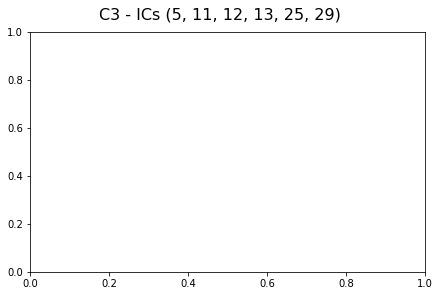

In [12]:
time_axis = reconstructed_train.times * 1000
channel_names = [['C3'], ['C1'], ['Cz'], ['C2'], ['C4']]
# channel_name = ['C3']
for channel_name in channel_names:
    fig, ax = plt.subplots(nrows = 1, ncols = 1, constrained_layout = True)
    fig.suptitle(f"{channel_name[0]} - ICs {chosen_idxs}", fontsize = 16)
    ax.plot(time_axis, np.squeeze(reconstructed_train["Left"].average().pick_channels(channel_name).get_data()), label='Left')
    ax.plot(time_axis, np.squeeze(reconstructed_train["Right"].average().pick_channels(channel_name).get_data()), label='Right')
    ax.plot(time_axis, np.squeeze(reconstructed_train["NoMove"].average().pick_channels(channel_name).get_data()), label='No Movement')
    ax.legend()